### Set standard imports

In [1]:
import matplotlib,lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import KiMoPack.plot_func as pf
#from KiMoPack.plotfunc import pf
from importlib import reload
reload(pf)

Plot_func version 6.12.6
was imported from path:
 H:\Programs\Anaconda\Lib\site-packages\KiMoPack
The current working folder is:
 H:\Dropbox\coding\github\KiMoPack\Workflow_tools
Plot_func version 6.12.6
was imported from path:
 H:\Programs\Anaconda\Lib\site-packages\KiMoPack
The current working folder is:
 H:\Dropbox\coding\github\KiMoPack\Workflow_tools


<module 'KiMoPack.plot_func' from 'H:\\Programs\\Anaconda\\lib\\site-packages\\KiMoPack\\plot_func.py'>

### Load and inspect Data 

In [2]:

#ta=pf.TA('sample_1.SIA',path='Data')   #type filename and path (leave path empty if in the same folder)
#ta=pf.TA("sample_1.hdf5",path="Data")  #reload saved projects using the same syntax
ta=pf.TA('gui')                       #use a GUI to select data


### perform standard corrections

In [3]:
debug=False   #turn on for checking
ta.intensity_range=ta.ds.describe().median(axis=1)['75%']*2
if debug:ta.Plot_RAW(0)
ta.Filter_data(value=0.001)               #remove bad data
if debug:ta.Plot_RAW(0)

attention, more than 20% of the data was removed by this filter.
Please check with if the spectal borders contain regions without light (and high noise)
Setting a bordercut and scattercut before the filtering might be useful
attention, more than 20% of the data was removed by this filter.
Please check with if the spectal borders contain regions without light (and high noise)
Setting a bordercut and scattercut before the filtering might be useful


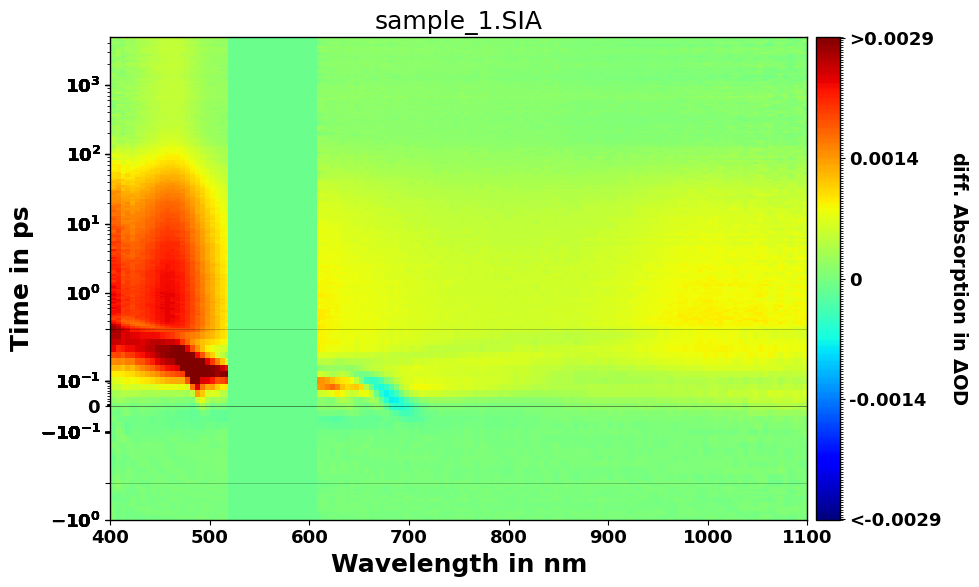

In [4]:
#ta.bordercut=[400,1150]
ta.Cor_Chirp() #correct for arrival time difference ta.Cor_Chirp('gui') allows to choose file 
ta.Background(uplimit=-0.5)           #substract Background before time_zero
ta.Plot_RAW(0)

In [ ]:
ta.par['t0'].vary=True
ta.par['resolution'].vary=True
ta.Fit_Global(confidence_level=0.95)

### Shape data and plot Raw images

In [ ]:
plt.close('all')
#ta.rel_wave=[390,420,440,530,580,700,800,950,930,1050]      # use to manually select interesting wavelength for the kinetics
ta.wavelength_bin=20                                         # width of wavelength bin in kinetics
ta.wave_nm_bin=5;                                            # rebinning wavelength
ta.rel_time=[0.3,0.4,1,3,5,10,20,30,100,300,2000,3000]          # use to manually set interesting times for the spectra
ta.time_width_percent=0                                      # rebinning of time_points in percent
ta.timelimits=[-1,5000]                                      # use to manually limit the range to plot (and fit)     
ta.log_scale=False                                           # use to plot the 2d plots with logarithmic intensity scale
ta.bordercut=[400,1100]                                      # use to set the outer wavelength limits
ta.scattercut=[522,605]                                      # this region is blanked out to block scatter, this can be a list of regions
ta.intensity_range=None#[0,3e-3]                                  # set a value 5e-3 or a range [-1e-3,5e-3] for 2d plotting
ta.Plot_RAW(title=None)                                      # Plot Raw Spectra

In [ ]:
self=ta.Copy()

In [ ]:
any([self.ignore_time_region is not None, self.scattercut is not None, self.bordercut is not None, self.timelimits is not None])

### Perform fast fitting using independent exponential decay (first order)

In [ ]:
ta.wave_nm_bin=2; 
plt.close('all')                                             # Close old spectra
ta.mod='exponential'                                         # Choose the model 'exponential', 'consecutive' and 'fast_consecutive'are build in
par=lmfit.Parameters()                                       # create empty parameter object

par.add('k0',value=1/0.1,vary=True)                                # Add second rate component
par.add('k1',value=1/2.5,vary=True)                                # Add one rate component
par.add('k2',value=1/40,vary=True)                                 # Add second rate component
par.add('t0',value=0,min=-2,max=2,vary=False)                       # Allow the arrival time to adjust (for all)
par.add('resolution',value=0.086,min=0.04,max=0.5,vary=False)       # Allow the instrument response to adjust (for all)
#par.add('infinite')                                                # Keyword for an non decaying component
#par.add('background')                                             # Keyword to fit the Background Disable the background substraction in the loading cell for best effect
#ta.timelimits=[0.2,5000]                                      # select time window in which to fit
ta.ignore_time_region=[-0.1,0.5]                              # ignore the region over t0 for the fit
ta.log_fit=False                                               # fit in linear or log scale
if 0:
    for key in par.keys():
        par[key].vary=False
ta.par=par                                                     # write parameter object into file for fitting
ta.Fit_Global(fit_chirp=False,dump_shapes=True)                                 # trigger fitting

ta.error_matrix_amplification=10;                              # Choose how much stronger should error be plotted       
ta.log_scale=False                                             # 2D plots in linear or log scale
ta.Plot_fit_output()                                 # plot the fit output

In [ ]:
par=lmfit.Parameters() 
par.add('k0',value=1/0.1,vary=True)                                
par.add('k1',value=1/2.5,vary=True)
par.add('k2',value=1/100,vary=True)
par.add('infinite')                               
par.add('t0',value=0,min=-2,max=2,vary=False)                 
par.add('resolution',value=0.086,min=0.04,max=0.5,vary=False)
ta.par=par # write parameter object into file for fitting
ta.Fit_Global(fit_chirp=False,confidence_level=0.95) 

In [ ]:
plt.close('all')
ta.cmap=pf.cm.gist_ncar
ta.intensity_range=3e-3
ta.Plot_fit_output()

### export the results as images and save the project

In [ ]:
#ta.filename='new'+ta.filename
ta.Save_project()                     # This saves the whole project including raw data, fits and chirp correction into a single file

In [ ]:
ta.Save_Plots(savetype='png')         # This saves all the figures and a overview powerpoint savetype=['png','svg']

### Perform Error analysis and calculate confidence interval

In [ ]:
ta.par=ta.par_fit #write the best results back as starting parameter
ta.Fit_Global(confidence_level=0.65)

### Perform fast iterative fitting using independent exponential decay and optimise the chirp

In [ ]:
ta1=ta.Copy()                          # Make a copy of the fitting ptoject to test less stable things
ta1.timelimits=None                    # To optimise the chirp the region around time-zero must be included
ta1.ignore_time_region=None            # To optimise the chirp the region around time-zero must be included
ta1.par=ta.par_fit                     # copy fitted parameter into a new fit (e.g. different model)
ta1.Fit_Global(fit_chirp=True)         # trigger fitting with Chirp optimization best using 'exponential' for speed
ta1.Plot_fit_output(title=None)        # plot the fit output

In [ ]:
ta=ta1.Copy() # if successful they can always be written back

### Perform fast fitting using consecutative exponential decay to obtain species associated spectrum assuming a simple model

In [ ]:
ta.mod='consecutive'             # very quick fit using independent exponential followed by one round of sequential
ta.par=ta.par_fit                # copy fitted parameter into a new fit (e.g. different model)
ta.Fit_Global(fit_chirp=False)   # The iterative chrip is best optimised using 'exponential'
ta.Plot_fit_output(title=None)   # plot the fit output

In [ ]:
ta.par=ta.par_fit
ta.mod='full_consecutive'        # Truely consecutative fitting, usually much slower
ta.Fit_Global(fit_chirp=False)   
ta.Plot_fit_output(title=None)

### Sometimes required options applicable also to fit plotting

In [ ]:
#ta.Man_Chirp()                   # used to redo the chirp-correction
#ta.Save_data()                   # used to dump the Data and fits to disk

#ta.cmap=pf.cm.viridis            # use different colour scheme (can also be a list of colours)
#pf.changefonts(weight='bold',font='standard',SMALL_SIZE=18,MEDIUM_SIZE=18,LARGE_SIZE=18)  

In [ ]:
ta.Save_Powerpoint()